In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
import random

In [2]:
!wget https://raw.githubusercontent.com/Prabhanshu-08/NLP-Guide/main/train.csv

--2023-02-20 14:54:20--  https://raw.githubusercontent.com/Prabhanshu-08/NLP-Guide/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  --.-KB/s    in 0.05s   

2023-02-20 14:54:20 (20.2 MB/s) - ‘train.csv’ saved [987712/987712]



In [3]:
# ! rm -f /root/.kaggle
# ! mkdir /root/.kaggle
# ! ls -al /root/.kaggle
# ! mv kaggle.json /root/.kaggle

# import kaggle

# !kaggle competitions download -c nlp-getting-started
# ! unzip -q /content/nlp-getting-started.zip

In [4]:
df_train = pd.read_csv('train.csv')

In [5]:
df_train=df_train[['text','target']]
df_train = df_train.sample(frac=1)

In [6]:
df_train.head()

,text,target
3161,Busty blonde teen Natalia Starr fucks the secu...,0
6505,How to Survive in the Markets http://t.co/LnzI...,0
2924,i drowned in the kiddie pool and i lost my ploppy,0
7026,abcnews - Obama Declares Disaster for Typhoon-...,1
6578,Breaking news: Haunting memories drawn by surv...,1


In [7]:
df_train.shape

(7613, 2)

In [8]:
df_train.isna().sum()

text      0
target    0
dtype: int64

EDA

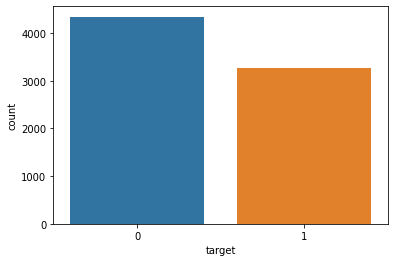

In [9]:
#0 means non disaster tweet and 1 means disaster tweet
sns.countplot(x=df_train['target']);

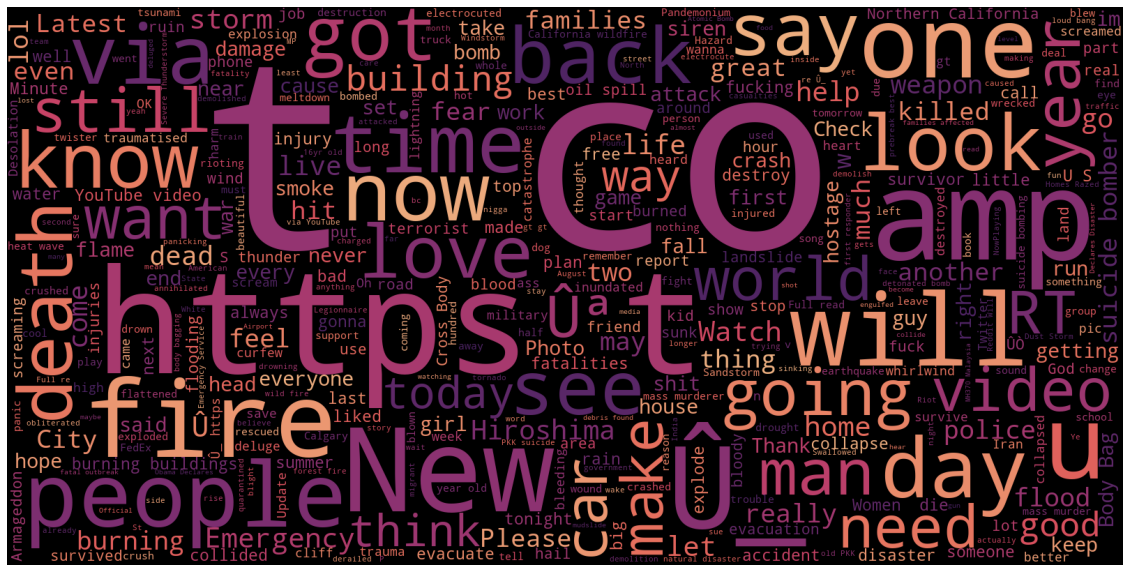

In [10]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 20))
Word_Cloud = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color='black', colormap='flare')\
                      .generate(' '.join(np.array(df_train['text'])))
plt.imshow(Word_Cloud)
plt.axis('off')
plt.show()

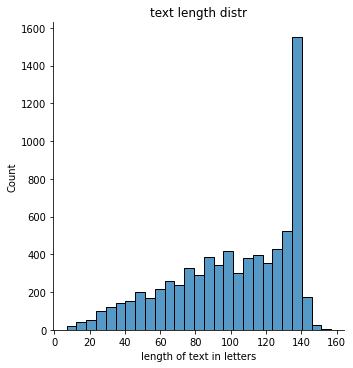

In [11]:
sns.displot(df_train.text.map(len)).set(xlabel='length of text in letters', title='text length distr');

In [12]:
#lets see some random tweets and their target
for i in range(5):
    i_loc = random.randint(0,len(df_train))
    print(f"Target : {df_train['target'].iloc[i_loc]}", "(Disaster tweet)" if df_train['target'].iloc[i_loc]>0 else "(Normal Tweet)")
    print(f"Text : {df_train['text'].iloc[i_loc]}\n")
    print('-----------------\n')

Target : 0 (Normal Tweet)
Text : RT: Our_Mother_Mary: Short Reading

Apocalypse 21:1023 

In the spirit the angel took me to the top of an enormous high mountain and... Û_

-----------------

Target : 1 (Disaster tweet)
Text : Anyone missing their license plate? Two stolen ones found on terrorist's car... http://t.co/CWGCciw3V6

-----------------

Target : 1 (Disaster tweet)
Text : Petition/No Medals for 1890 Massacre Justice for Wounded Knee Killings of Native Americans! http://t.co/UilPg8i1ev http://t.co/m9pXTo2kwW

-----------------

Target : 1 (Disaster tweet)
Text : Afghanistan: U.N. Reports 'Record-High Levels' of Civilian Casualties
    
In news from Afghanistan the United... http://t.co/YMcZyVKfmE

-----------------

Target : 0 (Normal Tweet)
Text : Evening Sun article on NNO: http://t.co/7cMf3noYNc

-----------------



In [13]:
#defining traning and validation data
from sklearn.model_selection import train_test_split

train_sen,val_sen,train_label,val_label = train_test_split(df_train['text'].to_numpy(),
                                                          df_train['target'].to_numpy(),
                                                          random_state=42,
                                                          test_size=.1)

In [14]:
train_sen

array(['@Sport_EN Just being linked to Arsenal causes injury.',
       '#Newswatch: 2 vehicles collided at Lock and Lansdowne Sts in #Ptbo. Emerg crews on their way',
       'There some flash flooding in madison #valleywx', ...,
       'smoke good fuck eat drink drive nice car wear all green mink',
       'Last chance to work at the old FFA foodstand at the fairgrounds. We are finishing demolition at 9am.  Any help would be appreciated',
       'Coastal German Shepherd Rescue OC shared a link... http://t.co/P85NwcMkQu #animalrescue | https://t.co/wUDlkq7ncx'],
      dtype=object)

Converting sentences into vectors in machine learning

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(['Convert this string to numbers'])

X.toarray()

array([[0.4472136, 0.4472136, 0.4472136, 0.4472136, 0.4472136]])

In [16]:
#using TfidfVectorizer to make an ML model

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Create tokenization and modelling pipeline
model_RF = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("rf", RandomForestClassifier()) # model the text
])

# Fit the pipeline to the training data
model_RF.fit(train_sen, train_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

In [17]:
#making an evaluation function to evaluate model performance
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

def evaluate_model(model,val_sen,val_label):
    y_preds = tf.round(np.squeeze(model.predict(val_sen)))
    accuracy = accuracy_score(val_label,y_preds)
    f1 = f1_score(val_label,y_preds)
    precision = precision_score(val_label,y_preds)
    recall = recall_score(val_label,y_preds)
    
    my_dict = {'Accuracy' : accuracy,
              'F1_score' : f1,
              'Precision' : precision,
              'Recall' : recall}
    
    return my_dict

In [18]:
results_RF = evaluate_model(model_RF,val_sen,val_label)
results_RF

{'Accuracy': 0.8031496062992126,
 'F1_score': 0.7524752475247526,
 'Precision': 0.8871595330739299,
 'Recall': 0.6532951289398281}

In [19]:
# !pip install LightGBM

import lightgbm

# Create tokenization and modelling pipeline
model_lgbm = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("rf", lightgbm.LGBMClassifier()) # model the text
])

# Fit the pipeline to the training data
model_lgbm.fit(train_sen, train_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('rf', LGBMClassifier())])

In [20]:
results_lgbm=evaluate_model(model_lgbm,val_sen,val_label)
results_lgbm

{'Accuracy': 0.7979002624671916,
 'F1_score': 0.763076923076923,
 'Precision': 0.8239202657807309,
 'Recall': 0.7106017191977078}

Converting sentences into vectors in deep learning

In [21]:
# Setup text vectorization
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

#setup embedding layer
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

In [22]:
#converting sentence in an array
text_vectorizer.adapt(train_sen)
sample_sent = 'Convert this sentence in array of numbers'
text_vectorizer([sample_sent])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,   19,    1,    4,    1,    6, 2843,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [23]:
# converting array into vectors
embedding(text_vectorizer([sample_sent]))

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02539193, -0.03897826, -0.00080663, ..., -0.00425025,
         -0.03564193, -0.03873607],
        [ 0.02836683,  0.03196744, -0.01439971, ..., -0.04148542,
         -0.01560446,  0.02649602],
        [-0.02539193, -0.03897826, -0.00080663, ..., -0.00425025,
         -0.03564193, -0.03873607],
        ...,
        [ 0.03308585, -0.04098906, -0.03602414, ...,  0.02496565,
         -0.04094274,  0.00381173],
        [ 0.03308585, -0.04098906, -0.03602414, ...,  0.02496565,
         -0.04094274,  0.00381173],
        [ 0.03308585, -0.04098906, -0.03602414, ...,  0.02496565,
         -0.04094274,  0.00381173]]], dtype=float32)>

Making a DL model

In [24]:
from tensorflow.keras import layers

#to take 1D input
inputs = layers.Input(shape=(1,), dtype="string") 

#to convert input sentences to array of length 15
x = text_vectorizer(inputs)

#to convert array into vectorsof shape (15,128)
x = embedding(x) 

#to reduce dimensions
x = layers.GlobalAveragePooling1D()(x)

#for 1D output
outputs = layers.Dense(1, activation="sigmoid")(x)

#Functional Model
model = tf.keras.Model(inputs, outputs, name="model_1_dense")

# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_history = model.fit(train_sen, 
                              train_label,
                              validation_data=(val_sen,val_label),
                              epochs=5
                              )

Epoch 1/5
215/215 [==============================] - 9s 36ms/step - loss: 0.6126 - accuracy: 0.6898 - val_loss: 0.5283 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.4447 - accuracy: 0.8170 - val_loss: 0.4517 - val_accuracy: 0.8005
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3508 - accuracy: 0.8572 - val_loss: 0.4365 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2878 - accuracy: 0.8892 - val_loss: 0.4431 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2400 - accuracy: 0.9117 - val_loss: 0.4615 - val_accuracy: 0.8071


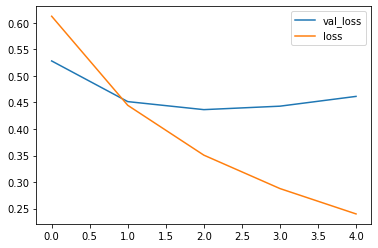

In [25]:
#loss curves
pd.DataFrame(model_history.history)[['val_loss','loss']].plot()

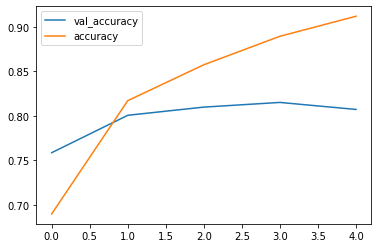

In [26]:
#accuracy curve
pd.DataFrame(model_history.history)[['val_accuracy','accuracy']].plot()

In [27]:
results_DL = evaluate_model(model,val_sen,val_label)
results_DL

24/24 [==============================] - 0s 2ms/step


{'Accuracy': 0.8070866141732284,
 'F1_score': 0.7755725190839694,
 'Precision': 0.8300653594771242,
 'Recall': 0.7277936962750716}

DL using transfer learning

In [28]:
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], 
                                        dtype=tf.string, 
                                        trainable=False, 
                                        name="USE") 

In [29]:
from tensorflow.keras import layers

model_USE = tf.keras.Sequential([
  sentence_encoder_layer, 
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")],
   name="model_USE")

# Compile model
model_USE.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_USE.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [30]:
# Train a classifier on top of pretrained embeddings
model_USE_history = model_USE.fit(train_sen,
                              train_label,
                              epochs=5,
                              validation_data=(val_sen, val_label),
                              shuffle=True
                              )

Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.5057 - accuracy: 0.7862 - val_loss: 0.4145 - val_accuracy: 0.8215
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4193 - accuracy: 0.8110 - val_loss: 0.4012 - val_accuracy: 0.8307
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4049 - accuracy: 0.8186 - val_loss: 0.3945 - val_accuracy: 0.8373
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3952 - accuracy: 0.8246 - val_loss: 0.3935 - val_accuracy: 0.8268
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3890 - accuracy: 0.8262 - val_loss: 0.3975 - val_accuracy: 0.8255


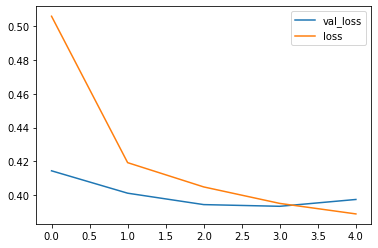

In [31]:
#loss curve
pd.DataFrame(model_USE_history.history)[['val_loss','loss']].plot()

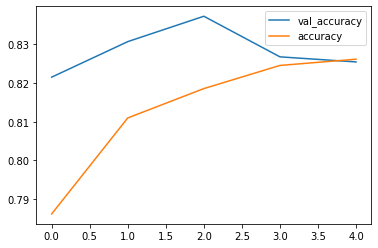

In [32]:
#accuracy curve
pd.DataFrame(model_USE_history.history)[['val_accuracy','accuracy']].plot()

In [33]:
results_TL = evaluate_model(model_USE,val_sen,val_label)
results_TL

24/24 [==============================] - 1s 10ms/step


{'Accuracy': 0.8254593175853019,
 'F1_score': 0.7950693374422187,
 'Precision': 0.86,
 'Recall': 0.7392550143266475}

In [39]:
evaluate_model(model_USE,val_sen,val_label)

24/24 [==============================] - 1s 20ms/step


{'Accuracy': 0.8254593175853019,
 'F1_score': 0.7950693374422187,
 'Precision': 0.86,
 'Recall': 0.7392550143266475}

In [34]:
all_models = pd.DataFrame({'RandomForestClassifier' : results_RF,
                           'LightGBM' : results_lgbm,
                           'Deep_Learning' : results_DL,
                           'Transfer_Learning' : results_TL})

In [35]:
all_models=all_models.T
all_models

,Accuracy,F1_score,Precision,Recall
RandomForestClassifier,0.803150,0.752475,0.887160,0.653295
LightGBM,0.797900,0.763077,0.823920,0.710602
Deep_Learning,0.807087,0.775573,0.830065,0.727794
Transfer_Learning,0.825459,0.795069,0.860000,0.739255


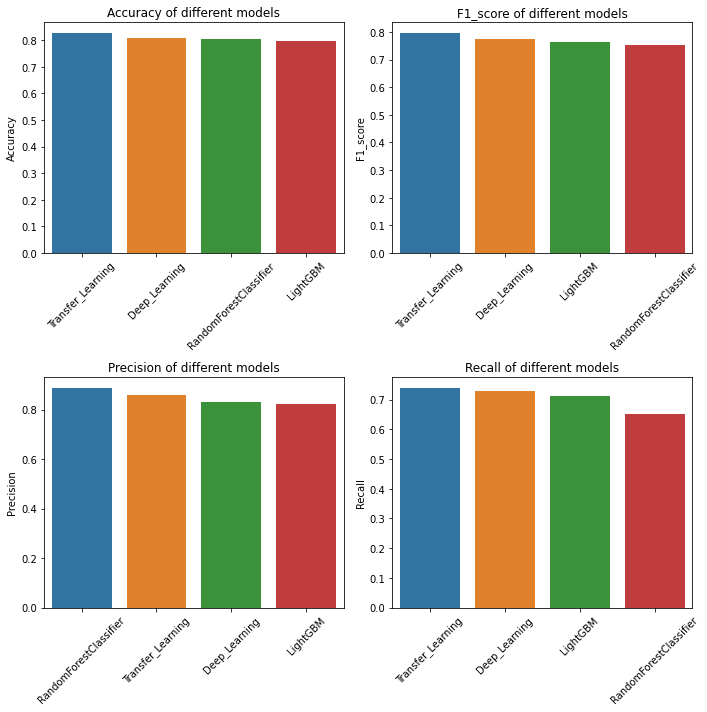

In [36]:
#plotting evaluation metrics for all models
plt.figure(figsize=(10,10))
for i,j in enumerate(all_models.columns):
  plt.subplot(2,2,i+1)
  sns.barplot(y=all_models[j],x=all_models.index,order=all_models[j].sort_values(ascending=False).index)
  plt.title(f'{j} of different models')
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
#making a function to make predictions on any tweet
def custom_prediction(text,model,deep_learning_model=True):
  """'text' is the tweet on which predictions is to be made,
  provide deep_learning_model=True if predictions needs to be made with a deep learning model"""

  if deep_learning_model==True:
    y_pred = round(model.predict([text],verbose=0)[0][0])
    if y_pred == 0:
      print('It is a non disaster tweet')
    elif y_pred == 1:
      print('It is a disaster tweet..Please alert the authorities')

  else :
    y_pred = model.predict([text])[0]
    if y_pred == 0:
      print('It is a non disaster tweet')
    elif y_pred == 1:
      print('It is a disaster tweet..Please alert the authorities')

In [51]:
test_sen_1 = 'Enjoying the aerial view of Himalayas..such a natural beauty'

print('Predictions using Deep Learning:')
custom_prediction(text=test_sen_1,model=model_USE) #using deep learning model
print('\nPredictions using Machine Learning:')
custom_prediction(text=test_sen_1,model=model_lgbm,deep_learning_model=False) # using machine learning model

Predictions using Deep Learning:
It is a non disaster tweet

Predictions using Machine Learning:
It is a non disaster tweet


In [52]:
test_sen_2 = 'There is flood on the street..Rescue team is on the way to help the victims'

print('Predictions using Deep Learning:')
custom_prediction(text=test_sen_2,model=model_USE) #using deep learning model
print('\nPredictions using Machine Learning:')
custom_prediction(text=test_sen_2,model=model_lgbm,deep_learning_model=False) # using machine learning model

Predictions using Deep Learning:
It is a disaster tweet..Please alert the authorities

Predictions using Machine Learning:
It is a disaster tweet..Please alert the authorities
